In [1]:
## popular python packages
import numpy as np
import itertools as it
from scipy.linalg import svd
import matplotlib.pyplot as plt
from dask_quantumtinkerer import Cluster, cluster_options

# packages used here
import kwant
from kwant.operator import Density

import sys, os
sys.path.append(os.path.realpath(sys.path[0] + '/..'))
from rootpath import ROOT_DIR

# pre-defined functions
sys.path.append(os.path.join(ROOT_DIR + '/code'))
from optimization import Optimize, configuration
import parameters
import tools as tl

sys.path.append("/home/tinkerer/spin-qubit/")
from Hamiltonian import discrete_system_coordinates

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [2]:
from constants import length_unit

In [3]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/srangaswamykup/trijunction_design/"

In [4]:
from tools import linear_Hamiltonian

# Y-shaped geometry

#### Parameters

In [5]:
import json
filename = 'config.json'
saveat = os.path.join(ROOT_DIR, 'code/')
with open(saveat + filename , 'r') as outfile:
    config = json.load(outfile)

In [6]:
change_config = [{'device':{'thickness': {'dielectric': 1}}}]

In [7]:
%%time

config, boundaries, poisson_system, linear_problem = configuration(config)

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix
CPU times: user 4min 38s, sys: 15.2 s, total: 4min 53s
Wall time: 4min 53s


In [201]:
import importlib
import optimization
importlib.reload(optimization)

<module 'optimization' from '/home/tinkerer/trijunction-design/code/optimization.py'>

In [202]:
optimize = optimization.Optimize(config, 
                    poisson_system,
                    linear_problem,
                    boundaries = boundaries, 
                    length_unit = 1e-8
                   )

In [170]:
%%time

args = optimize.params('left-right',
                optimal_phis = optimal_phis);

100%|██████████| 13/13 [00:28<00:00,  2.18s/it]


CPU times: user 33.5 s, sys: 199 ms, total: 33.7 s
Wall time: 33.7 s


In [162]:
optimize.set_voltages([-0.0036, -0.0086, -0.0086, -0.0036, -0.0037, -0.0037, -7e-05])

In [163]:
optimize.voltages

{'left_1': -0.0036,
 'left_2': -0.0086,
 'right_1': -0.0086,
 'right_2': -0.0036,
 'top_1': -0.0037,
 'top_2': -0.0037,
 'global_accumul': -7e-05,
 'dirichlet_0': 0.0,
 'dirichlet_1': 0.0,
 'dirichlet_2': 0.0,
 'dirichlet_3': 0.0,
 'dirichlet_4': 0.0,
 'dirichlet_5': 0.0}

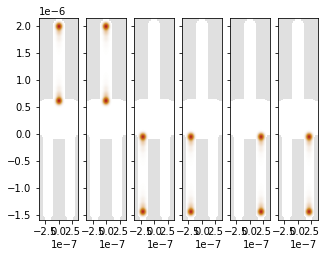

In [164]:
optimize.plot('DECOUPLED')

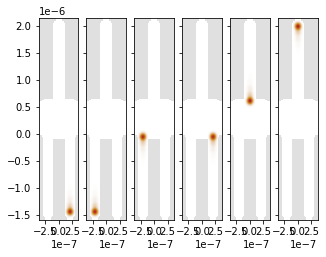

In [165]:
optimize.plot('WANNIER_FUNCTIONS')

In [232]:
initial_condition = [ -0.0014, -0.0014, -0.0037, 3e-3]

In [ ]:
optimal_voltages = optimize.optimize_gate('left-right', initial_condition, optimal_phis = optimal_phis)

100%|██████████| 13/13 [00:32<00:00,  2.47s/it]
/home/tinkerer/trijunction-design/code/optimization.py:668: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  acc_potential = potential_array[acc_points[i]]


0.022473780463731
0.02247475192860435
0.022474799304084206
0.022474603503255898
0.022472596402065413
| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | -1.4147e-02 | 1.00e-03 | 6.62e+01 | 0.00e+00 |
0.0111013070614758
0.011100828831778401
0.01110080331824292
0.011101289434518515
0.011101663601685612
|   2   |  10   |   1   | -1.4147e-02 | 5.00e-04 | 6.62e+01 | 0.00e+00 |
0.09382929262995528
0.09383000606773635
0.09382541500692598
0.09382933670847526
0.09383041944678978
|   3   |  15   |   2   | -7.7492e-02 | 3.50e-03 | 2.13e+02 | 0.00e+00 |
0.06948576292780557
0.06948437242415317
0.06948283922535752
0.06948468000755094
0.06948802582912272
|   4   |  20   |   5   | -7.7492e-02 | 1.30e-03 | 2.13e+02 | 0.00e+00 |
0.04708734908552377
0.04708819847836114
0.047092020281377
0.04708831266523625
0.04708549699401127
|   5   |  25   |   6   | -7.7492e-02 | 6.48e-04 | 2.13e+02 |

In [234]:
x = optimal_voltages

voltages = {}
    
voltages['left_1'] = x[0]
voltages['left_2'] = voltages['left_1']
voltages['right_1'] = x[1]
voltages['right_2'] = voltages['right_1']
voltages['top_1'] = x[2]
voltages['top_2'] = voltages['top_1']
voltages['global_accumul'] = x[3]

for i in range(6):
    voltages["dirichlet_" + str(i)] = 0.0

In [235]:
from potential import gate_potential

In [236]:
charges = {}
potential = gate_potential(
        poisson_system,
        linear_problem,
        optimize.site_coords[:, [0, 1]],
        optimize.site_indices,
        voltages,
        charges,
        offset = optimize.offset[[0, 1]],
        grid_spacing = optimize.length_unit
    )

potential.update((x, y*-1) for x, y in potential.items())

In [237]:
mu = parameters.bands[0]
params = parameters.junction_parameters(m_nw=[mu, mu, mu], m_qd=0)
params.update(potential=potential)

In [238]:
f_mu = optimize.f_params(**params)['mu']

In [239]:
def plot_f_mu(i):
    x, y = optimize.trijunction.sites[i].pos
    return f_mu(x, y)

In [240]:
kwant_sites = np.array(list(site.pos for site in optimize.trijunction.sites))

In [241]:
to_plot = [plot_f_mu(i) for i in range(len(kwant_sites))]

In [242]:
grid_points = poisson_system.grid.points
voltage_regions = poisson_system.regions.voltage.tag_points

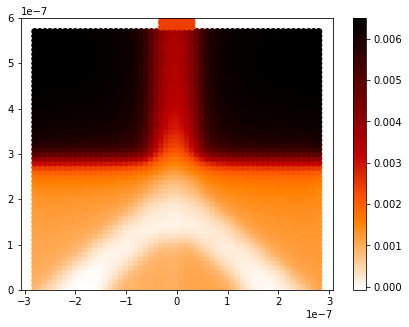

In [243]:
fig, ax = plt.subplots(1, 1, figsize = (7, 5))
cax = ax.scatter(kwant_sites[:, 0 ], kwant_sites[:, 1], 
                 c = np.array(to_plot), cmap = 'gist_heat_r'
                );
ax.set_ylim(0, 0.6e-6);
plt.colorbar(cax);
# plt.axis('equal')

In [244]:
from solvers import sort_eigen
import scipy.sparse.linalg as sla

In [245]:
summed_ham = sum(
[
        optimize.linear_ham[key] * voltages[key]
        for key, value in optimize.linear_ham.items()
    ]
)

tight_binding_hamiltonian = optimize.base_hamiltonian + summed_ham


eigval, eigvec = sort_eigen(sla.eigsh(tight_binding_hamiltonian.tocsc(), 
                                                   k=6, sigma = 0))

lowest_e_indices = np.argsort(np.abs(eigval))[: 6]
lowest_e_energies = eigval[lowest_e_indices]
coupled_states = eigvec.T[:, lowest_e_indices].T

# Overlap matrix
decoupled_states = optimize.mlwf
S = coupled_states @ decoupled_states.T.conj()

# Unitary matrix using SVD
U, _, Vh = svd(S)
S_prime = U @ Vh

# Transform coupled Hamiltonian to Majorana basis
coupled_ham = S_prime.T.conj() @ np.diag(lowest_e_energies) @ S_prime

print(np.abs((coupled_ham[2:5, 2:5])[0,2])/params['Delta'])

6.433918860907465e-07


In [255]:
phases = np.linspace(0, 2, 100) * np.pi

phis1 = [{"phi1": phi, "phi2": 0} for phi in phases]
phis2 = [{"phi2": phi, "phi1": 0} for phi in phases]
phis = [phis2, phis2, phis1]

solver = optimization._fixed_potential_solver(
    optimize.trijunction, optimize.f_params, params, eigenvecs=False
)
topo_gap = solver(phis[0][0])[0][-1]

In [258]:
print(np.abs((coupled_ham[2:5, 2:5])[0 , 1]) / topo_gap)

0.583034795739581


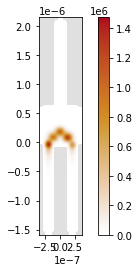

In [246]:
kwant.plotter.density(optimize.trijunction, optimize.densityoperator(coupled_states[-1]));

In [163]:
optimum_voltages = {}
with open("/home/tinkerer/trijunction-design/data/LR_voltages.pkl", 'rb') as infile:
    optimum_voltages['LR'] = pickle.load(infile)
    
with open("/home/tinkerer/trijunction-design/data/LC_voltages.pkl", 'rb') as infile:
    optimum_voltages['LC'] = pickle.load(infile)
    
with open("/home/tinkerer/trijunction-design/data/CR_voltages.pkl", 'rb') as infile:
    optimum_voltages['CR'] = pickle.load(infile)

100%|██████████| 7/7 [00:04<00:00,  1.46it/s]


0.00013948485514774731


100%|██████████| 7/7 [00:04<00:00,  1.52it/s]


0.00010258611045929488


100%|██████████| 7/7 [00:04<00:00,  1.42it/s]


0.00011244328071718932


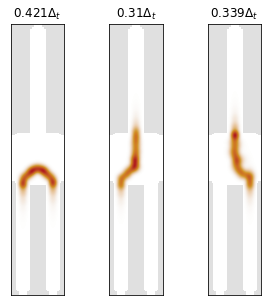

In [164]:
fig, ax = plt.subplots(1, 3, figsize = (5, 5), sharey = True)

coupling_strength = {}

for index, pairs in enumerate(zip([[0, 1], [0, 2], [1, 2]], ['LR', 'LC', 'CR'])):
    indices, pair = pairs
    
    base_hamiltonian, linear_ham = linear_Hamiltonian(poisson_params, 
                                                  kwant_params, 
                                                  params, 
                                                  list(voltage_regions.keys()),
                                                  phis = optimal_phis[pair])
    summed_ham = sum(
        [
            linear_ham[key] * optimum_voltages[pair][key]
            for key, value in linear_ham.items()
        ]
    )

    tight_binding_hamiltonian = base_hamiltonian + summed_ham


    eigval, eigvec = sort_eigen(sparse.linalg.eigsh(tight_binding_hamiltonian.tocsc(), 
                                                       k=6, sigma = 0))

    lowest_e_indices = np.argsort(np.abs(eigval))[: 6]
    lowest_e_energies = eigval[lowest_e_indices]
    coupled_states = eigvec.T[:, lowest_e_indices].T

    
    cax = kwant.plotter.density(trijunction, density(coupled_states[-1]), ax = ax[index]);
    
    ax[index].set_xticks([])
    ax[index].set_yticks([])

    # Overlap matrix
    decoupled_states = mlwf
    S = coupled_states @ decoupled_states.T.conj()

    # Unitary matrix using SVD
    U, _, Vh = svd(S)
    S_prime = U @ Vh

    # Transform coupled Hamiltonian to Majorana basis
    coupled_ham = S_prime.T.conj() @ np.diag(lowest_e_energies) @ S_prime

    print(np.abs((coupled_ham[2:5, 2:5])[indices[0], indices[1]]))
    
    
    coupling_strength[pair] = np.round(np.abs((coupled_ham[2:5, 2:5]/topo_gap)[indices[0], indices[1]]
                                                            ), 
                                                      3
                                                     )
    
    ax[index].set_title(r'${}\Delta_t$'.format(coupling_strength[pair]))

In [165]:
coupling_strength = {'LR': 0.421, 'LC': 0.31, 'CR': 0.339} #unit: Topological gap

{'LR': 0.421, 'LC': 0.31, 'CR': 0.339}